In [1]:
!pip install -q torchsummary
!pip -q install jcopdl


  Preparing metadata (setup.py) ... done


In [2]:
# pytorch 관련
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# 배열 수정 관련
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 그외 기본
from tqdm.auto import tqdm
from time import sleep
import os

# jcopdl 관련
import jcopdl
from jcopdl.callback import Callback

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# from jcopdl.callback import set_config

In [3]:
USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [4]:
from google.colab import files
!pip install -q kaggle #kaggle 설치

files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 
# ---------
# https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

Saving kaggle.json to kaggle.json
 81% 2.00M/2.47M [00:01<00:00, 2.23MB/s]
100% 2.47M/2.47M [00:01<00:00, 2.32MB/s]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/pokemon-images-and-types.zip
# 포켓몬 네임 파일이 인코딩 오류로 구글 드라이브에서 직접 다운


Archive:  /content/pokemon-images-and-types.zip
  inflating: images/images/abomasnow.png  
  inflating: images/images/abra.png  
  inflating: images/images/absol.png  
  inflating: images/images/accelgor.png  
  inflating: images/images/aegislash-blade.png  
  inflating: images/images/aerodactyl.png  
  inflating: images/images/aggron.png  
  inflating: images/images/aipom.png  
  inflating: images/images/alakazam.png  
  inflating: images/images/alomomola.png  
  inflating: images/images/altaria.png  
  inflating: images/images/amaura.png  
  inflating: images/images/ambipom.png  
  inflating: images/images/amoonguss.png  
  inflating: images/images/ampharos.png  
  inflating: images/images/anorith.png  
  inflating: images/images/araquanid.jpg  
  inflating: images/images/arbok.png  
  inflating: images/images/arcanine.png  
  inflating: images/images/arceus.png  
  inflating: images/images/archen.png  
  inflating: images/images/archeops.png  
  inflating: images/images/ariados.png 

In [7]:
WORKING_DIR = "/content/"
INFO_DIR = "drive/MyDrive/pokemon_name.csv"
IMAGES_DIR = "images/images/"

# config = set_config(dict(output_size=18, batch_size=4, image_size=(120, 120), lr=5e-4, dropout=0.5))

In [8]:
df = pd.read_csv(INFO_DIR, encoding = 'cp949')
df.head(10)

,EnglishName,KoreanName
0,bulbasaur,이상해씨
1,ivysaur,이상해풀
2,venusaur,이상해꽃
3,charmander,파이리
4,charmeleon,리자드
5,charizard,리자몽
6,squirtle,꼬부기
7,wartortle,어니부기
8,blastoise,거북왕
9,caterpie,캐터피


In [9]:
df2 = df.copy()

In [10]:
df2["KoreanName"].iloc[:721]

0      이상해씨
1      이상해풀
2      이상해꽃
3       파이리
4       리자드
       ... 
716    이벨타르
717    지가르데
718     디안시
719      후파
720    볼케니온
Name: KoreanName, Length: 721, dtype: object

In [11]:
# %%write dataset.py

from sklearn.preprocessing import OneHotEncoder, LabelEncoder


class PokemonDatasetBuilder():
    
    """
    A class used to generate the appropriate datasets.
    """
    def __init__(self, dataset_class, file_path, transform=None, splits=True):
        """
        dataset_class: one of {multilabel, multiclass}, determines the output of 
                       the dataset to be either one OneHotEncoded vector or two different labels.
                       
        file_path:     the file path to the csv file. 
        
        splits:        An optional condition to create a training, validation and testing set.
        """
        
        self._splits = splits
        self._dataset_class = dataset_class
        self.df = pd.read_csv(file_path, encoding = 'cp949')
        self.transform = transform
        self._preprocess_frame()
        
    def __call__(self, test_split=0.1, val_split=0.1):
        """
        Generates the datasets. 
        """
        
        dfs = []
        if self._splits:
            dfs.extend(self._create_splits(test_split, val_split))
        else:
            dfs.append(self.df)
        
        datasets = []
        
        # If multilabel, we don't encode type2 differently
        if self._dataset_class == "multilabel":
            OHE = OneHotEncoder(sparse=False, handle_unknown="ignore")
            OHE.fit(self.df[["EnglishName"]]) # type1 = 영어이름으로
            
            for df in dfs:
                datasets.append(PokemonDatasetMultilabel(df, OHE, self.transform))
            
        
        # If multiclass, we have to encode type1 and type2 differently, 
        # as we now have 19 targets for type2 (including None)
        else:
            LE1 = LabelEncoder()
            LE2 = LabelEncoder()
            
            LE1.fit(self.df["EnlishName"]) # 영어이름
            LE2.fit(self.df["KoreanName"]) # type2는 한글이름으로
        
            for df in dfs:
                datasets.append(PokemonDatasetMulticlass(df, LE1, LE2, self.transform))
        
        return datasets
            
            
    def _create_splits(self, test_split, val_split):
        """
        Helper function to create the different splits. 
        """
        df_test = self.df.sample(frac=test_split, random_state=42)
        df_train = self.df.drop(df_test.index)
        df_val = df_train.sample(frac=val_split, random_state=42)
        df_train = df_train.drop(df_val.index)

            
        return [df_train, df_val, df_test]

    
    def _preprocess_frame(self):
        """
        Helper function to preprocess the dataframe.
        """
        
        # 왜 갑자기 jpg파일이 생겨났을까? png, jpg파일을 따로 구분해준다
        self.df["EnglishName"].iloc[:721] = self.df["EnglishName"].iloc[:721].apply(lambda x : x + ".png")
        self.df["EnglishName"].iloc[721:] = self.df["EnglishName"].iloc[721:].apply(lambda x : x + ".jpg")
        self.df["EnglishName"].fillna("None", inplace=True) # 영어이름


In [13]:
class PokemonDatasetMultilabel(Dataset):
    """
    A dataset that returns a multilabel vector. The encoder passed to it should be a One hot encoder.
    """
    
    def __init__(self, df, encoder, transform=None):
        
        self.df = df
        self.transform = transform
        self.encoder = encoder
        self.type1 = encoder.transform(self.df[["EnglishName"]]) # 영어이름
        self.type2 = encoder.transform(self.df[["KoreanName"]]) # 한글이름
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_file = WORKING_DIR + IMAGES_DIR + self.df.iloc[idx, 0]
        
        image = process_image(image_file, self.transform)

        return image, (self.type1[idx] + self.type2[idx])

    
    def __len__(self):
        return self.df.shape[0]
    
    
    def get_labels_from_vector(self, vector):
        """
        Returns labels of a pokemon given a one hot encoded vector. 
        The output is formatted as type1, type2.
        
        >>> train_dataset = PokemonDatasetMultilabel(...)
        >>> vector = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
                     0.])
        >>> train_dataset.get_labels_from_vector(vector)
        ("Dark", "Ground")
        
        >>> vector = np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.])
        >>> train_dataset.get_labels_from_vector(vector)
        ("Fire", "None")
        """
        
        labels = self.encoder.categories_[0][vector==1]
        if vector.sum() == 1:
            return labels[0], "None"
        else:
            return tuple(labels)

    def get_labels_from_id(self, type1, type2=None):
        """
        Returns labels of a pokemon given both ids. 
        The output is formatted as type1, type2. 
        
        >>> train_dataset = PokemonDatasetMultilabel(...)
        >>> type1, type2  = (0, 15)
        >>> train_dataset.get_labels_from_id(type1, type2)
        ("Bug", "Rock")
        >>> train_dataset.get_labels_from_id(0)
        >>>("Bug", "None")
        """
        if type2 is not None: 
            return self.encoder.categories_[0][type1], self.encoder.categories_[0][type2]
        else:
            return self.encoder.categories_[0][type1], "None"


In [14]:
class PokemonDatasetMulticlass(Dataset):
    
    """
    A dataset that returns two outputs, which represent type1 and type2 respectively. 
    """
    def __init__(self, df, type_1_encoder, type_2_encoder, transform=None):
        
        self.df = df
        self.transform = transform
        
        self.type_1_encoder = type_1_encoder
        self.type_2_encoder = type_2_encoder
        
        self.type1 = type_1_encoder.transform(self.df["EnglishName"]) # 한글이름
        self.type2 = type_2_encoder.transform(self.df["KoreanName"]) # 영어이름
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_file = WORKING_DIR + IMAGES_DIR + self.df.iloc[idx, 0]
        image = process_image(image_file, self.transform)
        
        return image, self.type1[idx], self.type2[idx]
    
    def __len__(self):
        return self.df.shape[0]
    
    
    
    def get_labels(self, type1, type2):
        """
        Returns the labels of the pokemon given both ids.
        The output is formatted as type1, type2.
        """
        return self.type_1_encoder.classes_[type1], self.type_2_encoder.classes_[type2]
            
        
        
        
def process_image(image_file, transform=None):
    """
    Returns the image given the image file, and applies transform to it. 
    """
        
    # this converts PNG images to JPG images (RGBA to RGB), while giving both a white background instead of
    # a black background. 
    if image_file.split(".")[-1] == "png":
        pil_image = Image.open(image_file).convert("RGBA")
        image = Image.new('RGBA',pil_image.size,(255,255,255))
        image.paste(pil_image, (0,0), pil_image)
        image = image.convert("RGB")

    else:
        image = Image.open(image_file)


    if transform:
        image = transform(image)
        
    return image

In [15]:
def show_image(image, type1, type2):
    """
    Shows the image as well as the type of the pokemon. 
    """
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("Off")
    title = f"Pokemon name?: {type1}"
    if type2 != "None":
        title += f", {type2}"
    # plt.title(title)
    plt.title(title[:-4]) # 영어일 경우 jpg 무시

In [16]:
OUTPUT_TYPE = "multilabel" # 경로설정 때문에 씨름함. 이미지 로드는 성공

# transformations = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])
transformations = transforms.Compose([transforms.ToTensor()])
dataset_generator = PokemonDatasetBuilder(OUTPUT_TYPE, WORKING_DIR+INFO_DIR, transformations)
train_dataset, val_dataset, test_dataset = dataset_generator()

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle=True)
val_dataloader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [17]:
dataset_generator()

In [19]:
# train_dataset[0] # 이미지를 배열로 표시 (이상해씨에요)
train_dataset[0][0].shape

torch.Size([3, 120, 120])

# 데이터중 하나만 이미지 출력

In [24]:
# 한글화
plt.rc('font', family='NanumBarunGothic') 

In [25]:
plt.rcParams['font.family'] = 'NanumGothic'

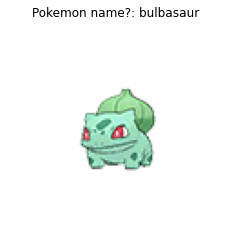

In [27]:
# Sample usage for multilabel 
pokemon = train_dataset[0]
show_image(pokemon[0], *train_dataset.get_labels_from_vector(pokemon[1]))

# Sample usage for multiclass
# show_image(pokemon[0], *train_dataset.get_labels(*pokemon[1:]))

# 모델 생성


In [28]:
class UnknownModeException(Exception):
    
    def __str__(self):
        return "Unknown mode given. Use one of: 'logistic', 'softmax', 'none'."  
        

In [29]:
class PokemonFCBlock(nn.Module):
    """
    The final layer for a PokemonCNN. 
    """
    
    def __init__(self, in_features, out_features, mode="none", dropout=0.2):
        """
        Initializes a new final layer.
        
        mode represents the final activation applied to the logits.
        {"logistic", "softmax", "none"}
        """
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features, 1000),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(), 
            nn.Dropout(dropout),
            nn.Linear(1000, out_features)
        )
        
        self.mode = mode.lower()
        
        
    def forward(self, x):
        
        if self.mode == "logistic":
            return torch.sigmoid(self.fc(x))
        elif self.mode == "softmax":
            return F.softmax(self.fc(x))
        elif self.mode == "none":
            return self.fc(x)
        else:
            raise UnknownModeException

In [30]:
class PokemonMultilabelCNN(nn.Module):
    """
    A CNN based on a base model that will output multilabel predictions. 
    The base model expects a ResNet architecture. 
    """
    
    def __init__(self, base_model, output_size, dropout):
        
        super().__init__()
    
        self.base_model = base_model 
        in_features = self.base_model.fc.in_features
        new_final = PokemonFCBlock(in_features, output_size, mode="logistic")
        self.base_model.fc = new_final

        
    def forward(self, x):
        return self.base_model(x)
    
    def freeze(self):
        # Freezes all the layers except for the final fully connected layer. 
        for name, child in self.base_model.named_children():
            if name != "fc":
                for param in child.parameters():
                    param.requires_grad = False 
            
    def unfreeze(self):
        for param in self.base_model.parameters():
            param.requires_grad = True
    
    

In [32]:
base_model = models.resnet50(pretrained=True, progress=False)
model = PokemonMultilabelCNN(base_model, 809, 0.5) # dropout = 0.5부터 테스트 시작
model.to(device)
model.freeze()
summary(model, (3, *(120,120)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]           9,408
       BatchNorm2d-2           [-1, 64, 60, 60]             128
              ReLU-3           [-1, 64, 60, 60]               0
         MaxPool2d-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]           4,096
       BatchNorm2d-6           [-1, 64, 30, 30]             128
              ReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]          36,864
       BatchNorm2d-9           [-1, 64, 30, 30]             128
             ReLU-10           [-1, 64, 30, 30]               0
           Conv2d-11          [-1, 256, 30, 30]          16,384
      BatchNorm2d-12          [-1, 256, 30, 30]             512
           Conv2d-13          [-1, 256, 30, 30]          16,384
      BatchNorm2d-14          [-1, 256,

In [45]:
# 패러미터 조정. callback은 미사용
# optimizer 계속 조정할 필요성을 느낍니다

criterion = nn.BCELoss() # 초기 BCELoss
optimizer= torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay = 1e-1) # 최초 lr =  5e-4, weight decay는 미설정
# callback = Callback(model, config, early_stop_patience=10, outdir="model")

In [46]:
class ModelTrainer():
    """
    Abstract base class for model trainers.
    """
    
    def __init__(self, model, optimizer, criterion, device):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        # self.callback = callback
        self.epoch = 1
        
    def train_loop(self, dataloader, epoch=22):
        """
        Trains the model for a single loop, i.e one epoch
        The optional argument epoch indicates which epoch this training loop belongs to.
        """
        raise NotImplementedError
        
    def validate_loop(self, dataloader):
        """
        Validate the model. 
        """
        raise NotImplementedError
        
    def train(self, train_dataloader, val_dataloader):
        """
        Trains the model for multiple epochs, and validates the model every epoch. 
        """
        raise NotImplementedError
        


In [47]:
class MultilabelModelTrainer(ModelTrainer):
    """
    A multilabel model trainer.
    """
    
    def __init__(self, model, optimizer, criterion, device):
        
        super(MultilabelModelTrainer, self).__init__(model, optimizer, criterion, device)
    
        
    def train_loop(self, dataloader, epoch=10):
        
        self.model.train()
        cost = 0 
        t = tqdm(dataloader)
        if epoch:
            t.set_description(f"Training mode, Epoch {self.epoch}")
            
        for feature, target in t:
            feature, target = feature.to(self.device), target.to(self.device)
            output = self.model(feature).double() # resolves expected dtype Double but got dtype Float
            loss = self.criterion(output, target)
            loss.backward()
            
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            cost += loss.item() * feature.shape[0]
        
        return cost / len(dataloader.dataset)
            
        
    def validate_loop(self, dataloader):
        
        self.model.eval()
        cost = 0
        with torch.no_grad():
            for feature, target in tqdm(dataloader, desc="Validation mode"):
                feature, target = feature.to(self.device), target.to(self.device)
                output = self.model(feature).double()
                loss = self.criterion(output, target)
                
                cost += loss.item() * feature.shape[0]
        
        return cost/len(dataloader.dataset)
        
        
    def train(self, train_dataloader, val_dataloader):
        train_graph = []
        val_graph = []
        for _ in range(1, 10):
            train_cost = self.train_loop(train_dataloader)
            val_cost = self.validate_loop(val_dataloader)
            val_graph.append(val_cost)
            train_graph.append(train_cost)
            self.epoch += 1
                      
            print(f'1) 학습 cost : {train_cost},\n2) 검증 cost : {val_cost}')
            

            # Prevents weird output
#             _ = self.callback.log(train_cost, val_cost)
#             _ = self.callback.save_checkpoint()
# #             _ = self.callback.cost_runtime_plotting()
        
#             if self.callback.early_stopping(model, monitor="test_cost"):
#                 self.callback.plot_cost()

# 평가 함수



criterion = MSELoss, lr = 0.0001, weight decay = 미설정
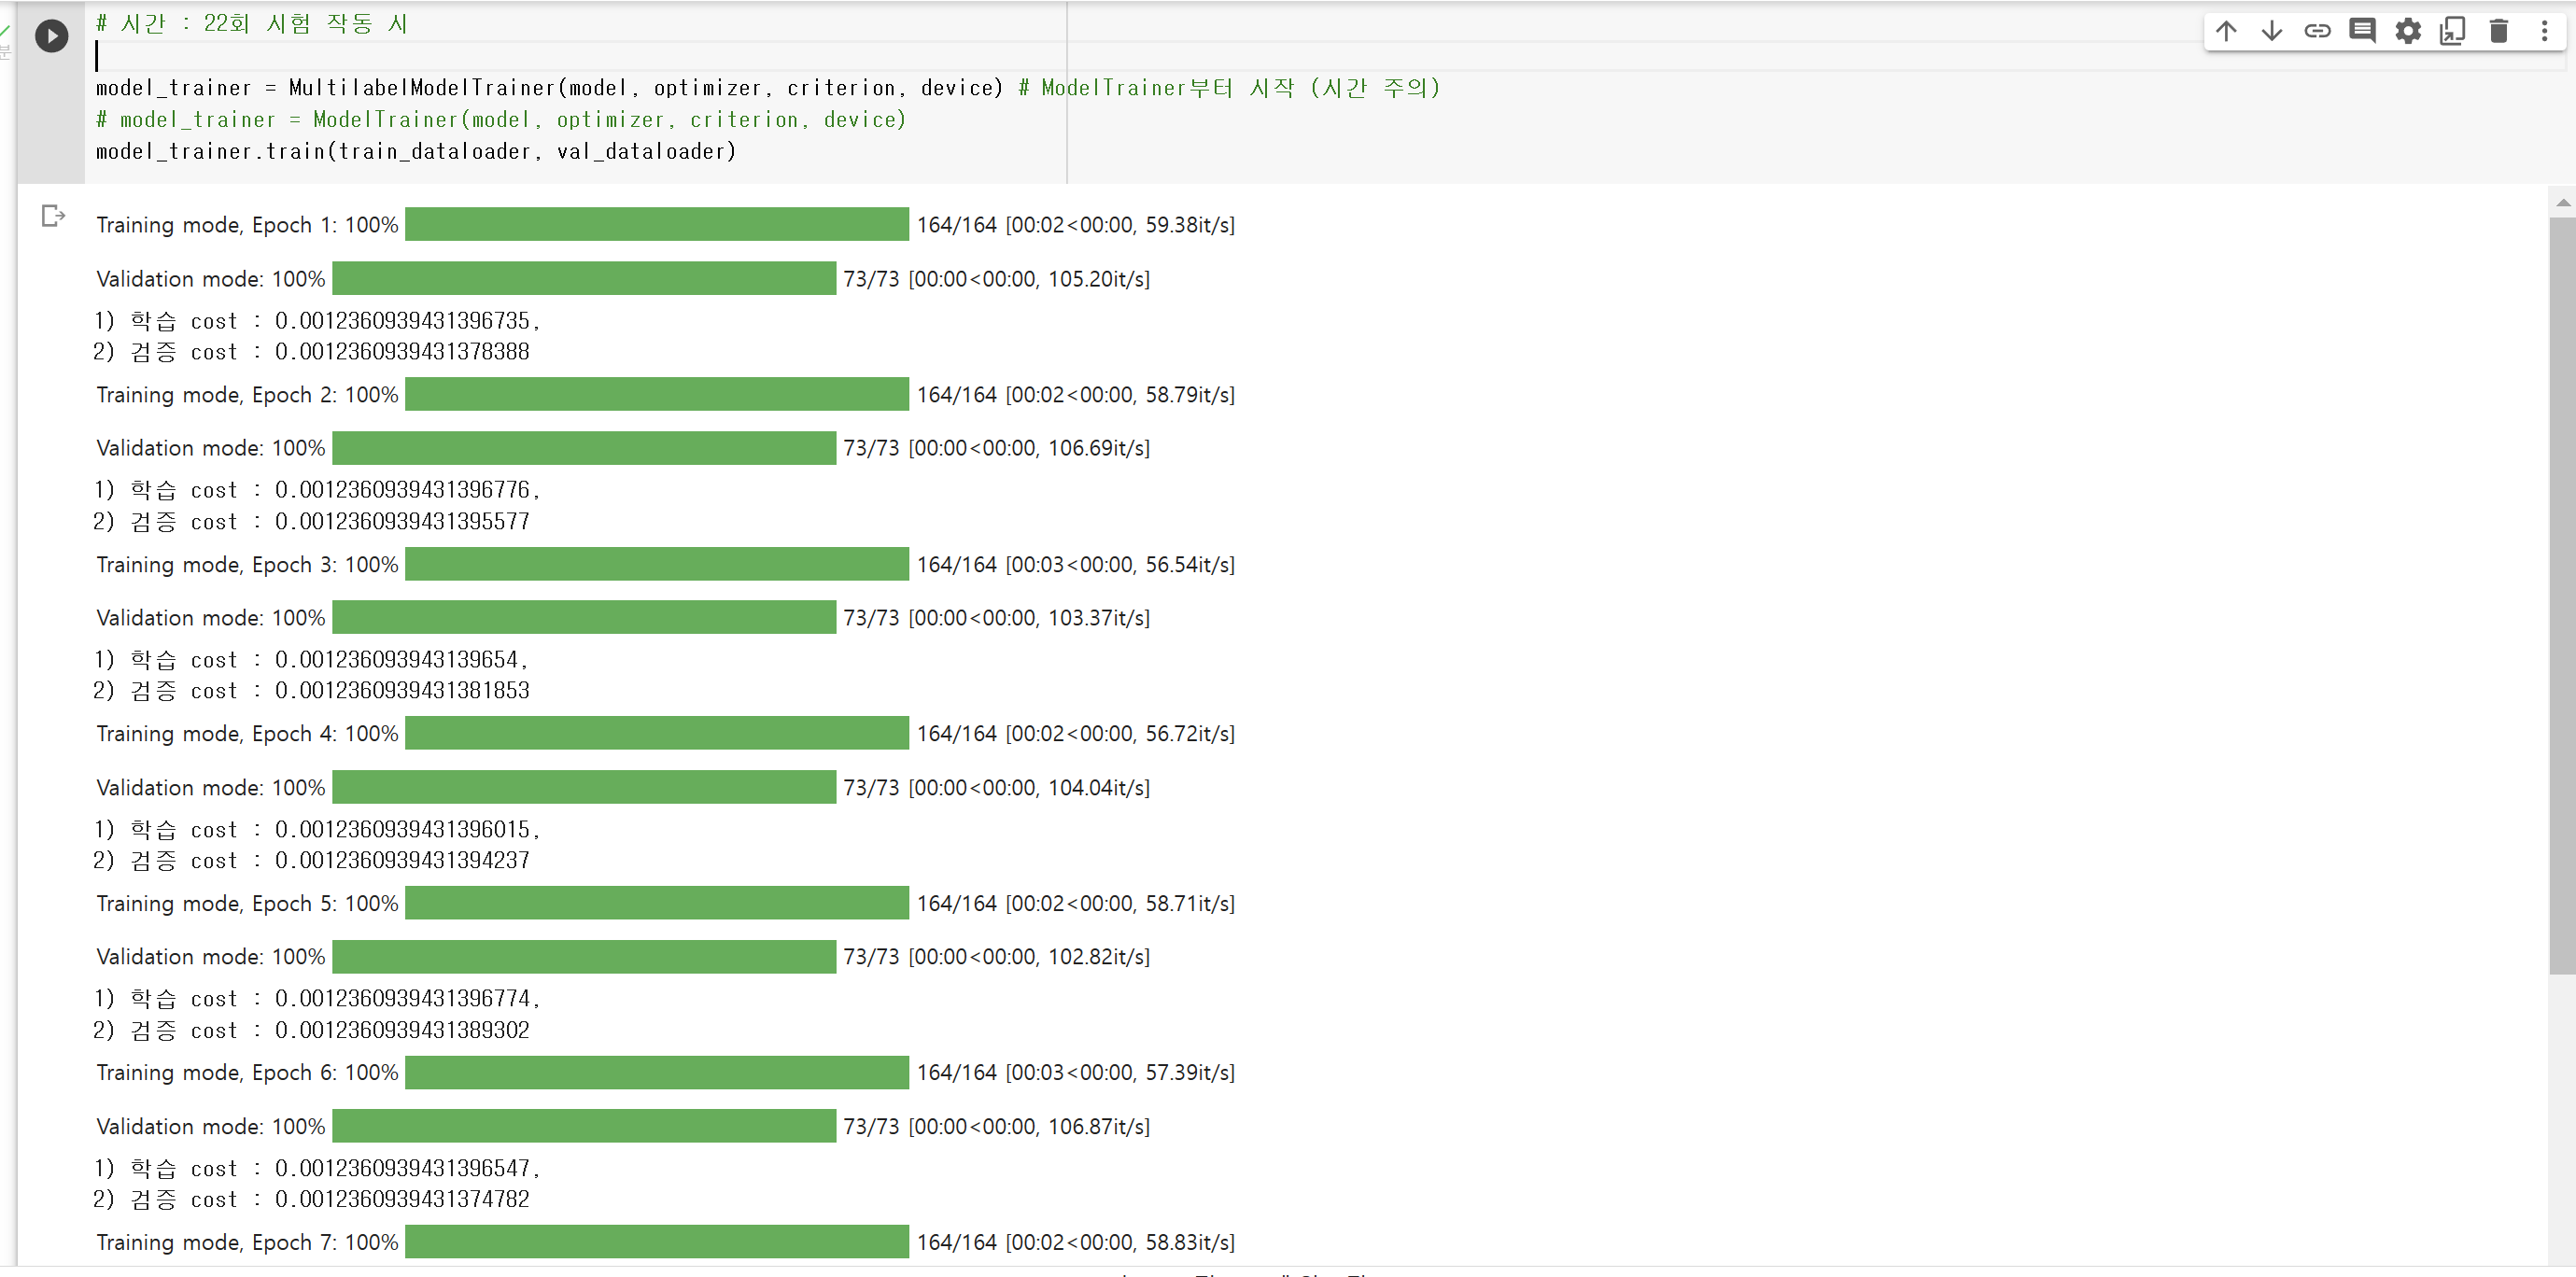

In [48]:
# 시간 체크
# 에포크 숫자가 따로 나와있지 않음 (10으로 강제 설정)
# 시간 : 22회 시험 작동 시 : 1분 30초


model_trainer = MultilabelModelTrainer(model, optimizer, criterion, device) # ModelTrainer부터 시작 (시간 주의)
model_trainer = ModelTrainer(model, optimizer, criterion, device)
model_trainer.train(train_dataloader, val_dataloader)

  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.10623481829968057,
2) 검증 cost : 0.12360939431396803


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12341075777691092,
2) 검증 cost : 0.12360939431396803


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12323625213753607,
2) 검증 cost : 0.1236093943139681


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.1224716083468656,
2) 검증 cost : 0.12360939431396935


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12211577851241434,
2) 검증 cost : 0.12311957922983015


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.120759765281065,
2) 검증 cost : 0.12106586749743552


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.19397287608438543,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24684135536285473,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24684135536285476,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24684135536285473,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24684135536285473,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24684135536285495,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24672778377928745,
2) 검증 cost : 0.24721878862793908


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24663314935257957,
2) 검증 cost : 0.24721878862794405


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24651911492528067,
2) 검증 cost : 0.24676682235139177


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24597187672457813,
2) 검증 cost : 0.24349136189135376


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.2600252112814089,
2) 검증 cost : 0.24721878862793606


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.24536453706481376,
2) 검증 cost : 0.12360939431396803


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12360939431396778,
2) 검증 cost : 0.12360939431396803


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12360939431396778,
2) 검증 cost : 0.12360939431396803


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 0.12360939431396778,
2) 검증 cost : 0.12360939431396803


In [251]:
import random

random_idx = random.randint(0, len(train_dataset)-1)
pokemon = train_dataset[random_idx]
with torch.no_grad():
    feature = pokemon[0].to(device)
    prediction = model(feature.unsqueeze(0))

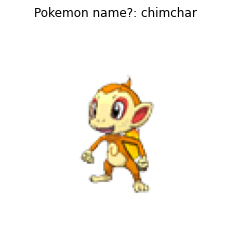

In [252]:
show_image(pokemon[0], *train_dataset.get_labels_from_vector(pokemon[1]))

In [256]:
predicted_labels = prediction.squeeze(0).argsort()
type2, type1 = predicted_labels[-2], predicted_labels[-1]

if prediction.squeeze(0)[type1] - prediction.squeeze(0)[type2] >= 0.2:
    print(train_dataset.get_labels_from_id(type1))    
    print(f"{type1}: {prediction.squeeze(0)[type1]}")
else:
    print(train_dataset.get_labels_from_id(type1, type2))
    print(f"{type1}: {prediction.squeeze(0)[type1]}")

('lunala.jpg', 'unown.png')
387: 0.003033293876796961
741: 0.002205628203228116
